In [538]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
import seaborn as sns
from ngboost import NGBRegressor
import random
from scipy.stats import trim_mean

from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, RidgeCV
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor

In [539]:
# Import Data
X_train_np = np.load("../VAE_Data/X_train.npy", allow_pickle=True).astype(np.float64)
X_test_np = np.load("../VAE_data/X_test.npy", allow_pickle=True).astype(np.float64)
y_train_np = np.load("../VAE_data/y_train.npy", allow_pickle=True).astype(np.float64)
y_test_np = np.load("../VAE_Data/y_test.npy", allow_pickle=True).astype(np.float64)

X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape

((14196, 2640), (1586, 2640), (14196, 1890), (1586, 1890))

In [540]:
# Combine train and test data for scaling
X_combined = np.vstack((X_train_np, X_test_np))
y_combined = np.vstack((y_train_np, y_test_np))

In [541]:
def plotXYrelationship(X: np.array, y: np.array, Xcolumn: int, ycolumn: int):
    assert Xcolumn >= 748 and Xcolumn < 2640
    assert ycolumn < 1890
    plt.figure(figsize=(10,6))
    X_data = X[:, Xcolumn]
    Y_data = y[:, ycolumn]
    colors = np.random.rand(50)
    plt.scatter(X_data, Y_data)
    plt.show()

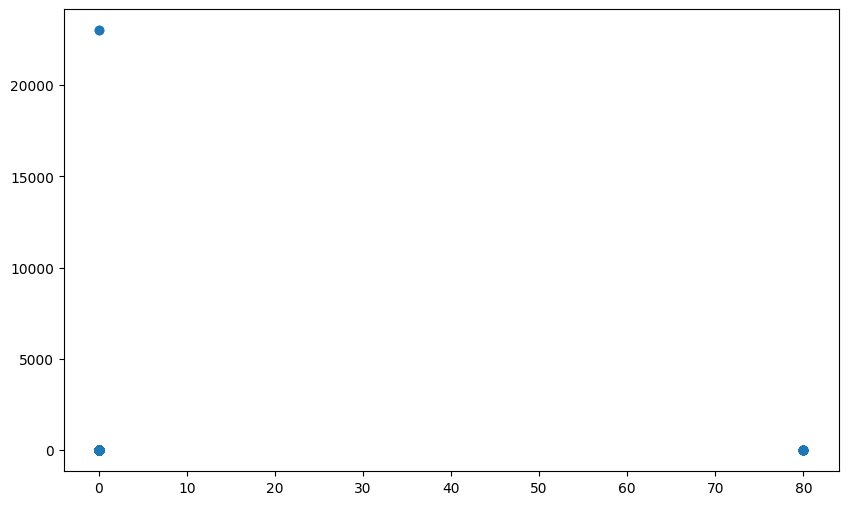

In [542]:
plotXYrelationship(X_combined, y_combined, 2200, 418)

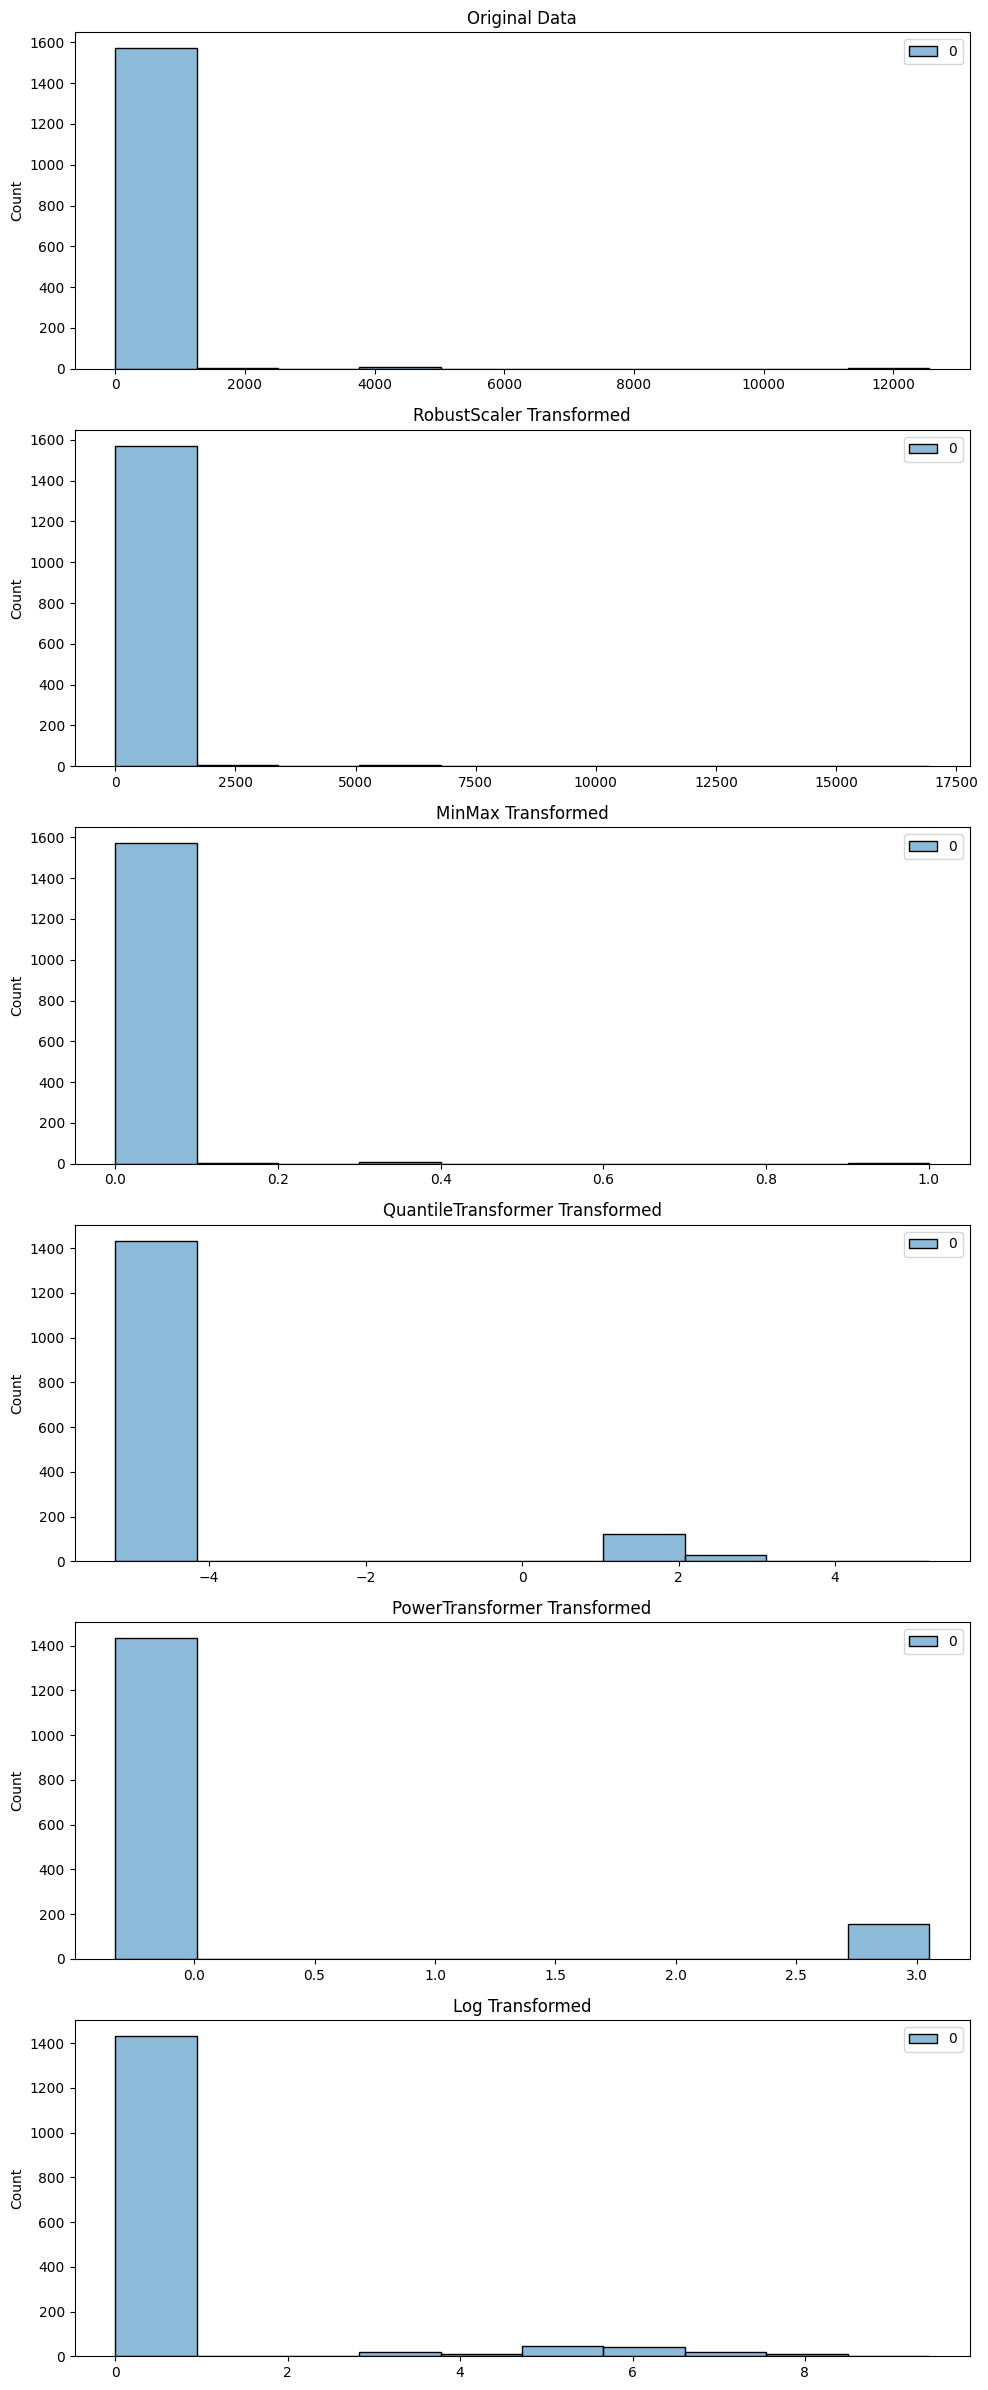

In [543]:
data = y_test_np[:,98].reshape(-1,1)
scalers = {
    'RobustScaler': RobustScaler(unit_variance=True),
    'MinMax': MinMaxScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal'),
    'PowerTransformer': PowerTransformer(method='yeo-johnson'),
    'Log': lambda X: np.log1p(data)
}

fig, axes = plt.subplots(len(scalers) + 1, 1, figsize=(10, 4 * (len(scalers) + 1)))

sns.histplot(data, ax=axes[0], bins=10)
axes[0].set_title('Original Data')

for i, (name, scaler) in enumerate(scalers.items(), 1):
    if callable(scaler):
        X_scaled = scaler(data)
    else:
        X_scaled = scaler.fit_transform(data)
    sns.histplot(X_scaled, ax=axes[i], bins=10)
    axes[i].set_title(f'{name} Transformed')

plt.tight_layout()
plt.show()

In [544]:

# Split the shuffled, scaled data back into train and test sets
#test_size = len(X_test_np) / len(X_combined)  # Calculate the original test set proportion
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.25, random_state=42, shuffle=True
)

X_combined = np.vstack((X_train, X_test))
y_combined = np.vstack((y_train, y_test))

# Scale the Data
scaler = RobustScaler()
X_scaled = X_combined.copy()

# Don't scale before 748 because of 1 hot encodings
X_scaled[:, 749:] = scaler.fit_transform(X_combined[:, 749:])
ordinal_days_scaler = MinMaxScaler()
X_scaled[:, 748] = ordinal_days_scaler.fit_transform(X_combined[:, 748].reshape(-1, 1)).ravel()


# Scale y values
y_scaler = RobustScaler()
y_scaled = y_scaler.fit_transform(y_combined)


X_train_scaled = X_scaled[:len(X_train),:]
X_test_scaled = X_scaled[len(X_train):, :]
y_train_scaled = y_scaled[:len(y_train),:]
y_test_scaled = y_scaled[len(y_train):,:]


In [545]:
y_combined.shape

(15782, 1890)

In [546]:
X_train_scaled.shape, X_test_scaled.shape, y_train_scaled.shape, y_test_scaled.shape

((11836, 2640), (3946, 2640), (11836, 1890), (3946, 1890))

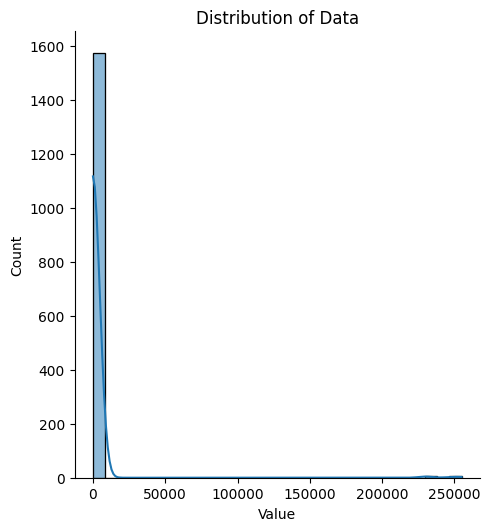

In [547]:
data = y_test_np[:,426]
sns.displot(data, kde=True, bins=30)
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [548]:
value = 10
columns_with_values_gt_value = np.where(np.any(y_test_np > value, axis=0))[0]

print(f"Total Unit Price Columns: {len(y_test_np)}")
print(f"Unit Price Columns with at least one value greater than {value}: {len(columns_with_values_gt_value)}")


Total Unit Price Columns: 1586
Unit Price Columns with at least one value greater than 10: 933


In [549]:
EligiblePayItemIndexes = pd.read_csv("../eligibleBidItems.csv")
EligiblePayItemIndexes = EligiblePayItemIndexes.rename(columns={'0': 'ITEM NO.'})
GADOTPayItemIndexes = pd.read_csv("../PayItemIndex_2021.csv")

In [550]:
print(EligiblePayItemIndexes.head())
print(GADOTPayItemIndexes.head())


   ITEM NO.
0  009-3000
1  110-1000
2  149-0100
3  150-0008
4  150-0009
   ITEM NO. UNITS LS UNITS                                DESCRIPTION
0  001-1000     *      NaN                          FORCE ACCOUNT NO.
1  001-1900   *$*      NaN  STATE AID PROJECT - LIMITED PARTICIPATION
2  001-1999   *$*      NaN        CONSTRUCTION ENGINEERING INSPECTION
3  001-2000    WD      NaN                   CONSTRUCTION ENGINEERING
4  001-2001    HR      NaN                           SENIOR INSPECTOR


In [551]:
#unitpricecolumn = random.sample(list(columns_with_values_gt_value), k=1)[0]
#unitpricecolumn
merged_items = pd.merge(EligiblePayItemIndexes, GADOTPayItemIndexes[['ITEM NO.', 'DESCRIPTION']], 
                        on='ITEM NO.', how='left')
asphalt_columns = []
for unitpricecol in range(0, y_test.shape[1]):
    GADOTitem = merged_items.iloc[unitpricecol]
    if 'ASPH' in str(GADOTitem['DESCRIPTION']):
        asphalt_columns.append(unitpricecol)
# Only attempt to sample if asphalt_columns is not empty
print(asphalt_columns)
if asphalt_columns:
    unitpricecolumn = random.sample(asphalt_columns, k=1)[0]
    print(unitpricecolumn)
else:
    print("No asphalt columns found")

[1, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 154, 155, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 194, 288, 1866]
135


In [552]:
model = GradientBoostingRegressor(
        validation_fraction=0.1, 
        loss='huber',
        verbose=1,
        n_estimators=200,
        n_iter_no_change=10,
        subsample=0.9,
        max_depth=30,
        learning_rate=0.01,
        random_state=42
)


model_backup = KNeighborsRegressor(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    n_jobs=-1,
    leaf_size=50
)


""" model = HistGradientBoostingRegressor(loss="quantile",
                                      quantile=0.1,
                                      max_iter=100,
                                      validation_fraction=0.1,
                                      n_iter_no_change=20,
                                      verbose=1,
                                      random_state=42,
                                      max_leaf_nodes=1000,
                                     )
"""
model.fit(X_train_scaled, y_train_scaled[:,unitpricecolumn])
#scores = cross_val_score(model, X_train_scaled, y_train_scaled[:,unitpricecolumn], cv=5, scoring='neg_mean_squared_error')
#print(f'Gradient Booting Regressor Scores: {scores}')
model_backup.fit(X_train, y_train[:,unitpricecolumn])
#scores = cross_val_score(model_backup, X_train, y_train[:,unitpricecolumn], cv=5, scoring='neg_mean_squared_error')
#print(f'K Neighbors Regressor Scores: {scores}')



      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1979.8859       -2039.8076           57.78s
         2        1959.1742         195.8773           57.28s
         3        1896.5636        -176.9558           56.60s
         4        1898.4293         386.9464           56.42s
         5        1850.9206         -71.2368           56.30s
         6        1789.8291        -194.5893           56.04s
         7        1761.5346          92.2268           55.69s
         8        1731.8629          75.9762           55.59s
         9        1676.6167        -157.2872           55.35s
        10        1679.8832         355.5335           55.11s
        20        1388.0684         133.3884           51.95s
        30        1122.8199        -146.8619           49.95s
        40         947.6550         138.3628           47.77s
        50         773.3518         -42.2095           45.17s
        60         640.7165         -85.8057           42.54s
       

KNeighborsRegressor(leaf_size=50, n_jobs=-1, weights='distance')

In [553]:
y_preds = model.predict(X_test_scaled)
y_preds_backup = model_backup.predict(X_test)

In [554]:
def inverse_transform_Y_preds(unit_price_column: int, y_preds: np.array) -> np.array:
    n = unit_price_column  # The column you're predicting
    
    # Create a dummy array the size of your original combined dataset
    dummy_array = np.zeros((len(y_combined), y_scaler.n_features_in_))
    
    # Fill in the known values from your training set
    dummy_array[:len(y_train_scaled)] = y_scaler.transform(y_train_scaled)
    
    # Add your predictions for the test set
    dummy_array[len(y_train_scaled):, n] = y_preds
    
    # Inverse transform
    inverse_transformed = y_scaler.inverse_transform(dummy_array)
    
    # Extract only the relevant portion (the test set predictions)
    original_scale_predictions = np.round(inverse_transformed[len(y_train_scaled):, n],decimals=1)
    return original_scale_predictions


In [555]:
UnitPrice_model_predictions = inverse_transform_Y_preds(unit_price_column=unitpricecolumn, y_preds=y_preds)
UnitPrice_model_predictions_backup = np.round(y_preds_backup, decimals=1)

In [556]:
y_difference = UnitPrice_model_predictions - y_test[:,unitpricecolumn]
y_difference_backup = UnitPrice_model_predictions_backup - y_test[:, unitpricecolumn]

if (trim_mean(y_difference, proportiontocut=0.2) < trim_mean(y_difference_backup, proportiontocut=0.2)):
    print("USE OG MODEL")
else:
    print("USE BACKUP MODEL")
    UnitPrice_model_predictions = UnitPrice_model_predictions_backup
    y_difference = y_difference_backup

USE OG MODEL


In [557]:
def createResultsDataframe(unitpricecolumn, UnitPrice_model_predictions, y_difference):
    pred_dict = {}
    pred_dict["Y True"]  = y_test[:,unitpricecolumn]
    
    pred_dict["Y Pred"] = UnitPrice_model_predictions
    
    pred_dict["Difference"] = y_difference
    dataframe = pd.DataFrame.from_dict(pred_dict, orient='index').T.astype(float)
    return dataframe

In [558]:
yTruePredDiffDataframe = createResultsDataframe(unitpricecolumn=unitpricecolumn, 
                                                UnitPrice_model_predictions=UnitPrice_model_predictions, 
                                                y_difference=y_difference)
yTruePredDiffDataframe

Y True  Y Pred  Difference
0        0.0     0.0         0.0
1        0.0     0.0         0.0
2        0.0     0.0         0.0
3        0.0     0.0         0.0
4       76.5    66.3       -10.2
...      ...     ...         ...
3941     0.0     0.0         0.0
3942     0.0     0.0         0.0
3943     0.0     0.0         0.0
3944     0.0     0.0         0.0
3945     0.0     0.0         0.0

[3946 rows x 3 columns]

In [559]:
yTruePredDiffDataframe[abs(yTruePredDiffDataframe["Difference"]) > (0.10 * yTruePredDiffDataframe["Y True"])].head(10)


Y True  Y Pred  Difference
4    76.50    66.3      -10.20
19   97.00    84.3      -12.70
28   85.40    74.1      -11.30
31   80.00    68.2      -11.80
39   96.00    82.3      -13.70
40   97.00    84.1      -12.90
48   98.00    83.7      -14.30
55   74.50    65.2       -9.30
58  102.76    91.7      -11.06
74   67.38    59.9       -7.48

In [560]:
len(yTruePredDiffDataframe[abs(yTruePredDiffDataframe["Difference"]) > (0.10 * yTruePredDiffDataframe["Y True"])])

621

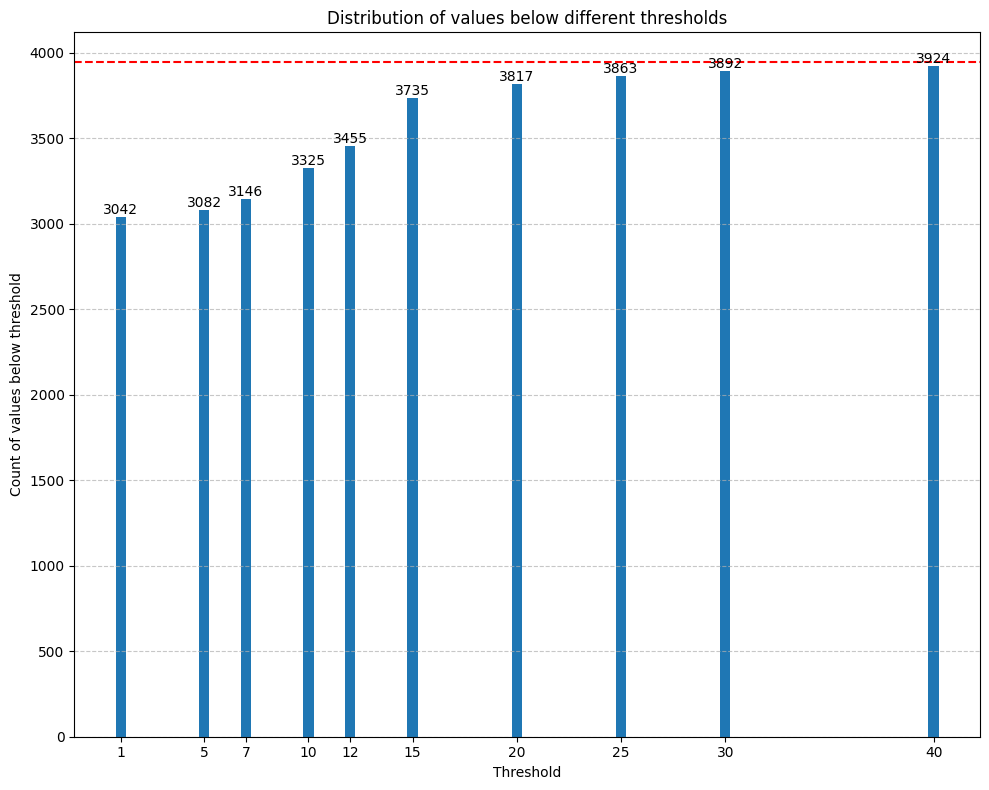

Unit ITEM: 402-3130
	DESC: RECYCLED ASPH CONC 12.5 MM SUPERPAVE, GP 2 ONLY, INCL BITUM MATL & H LIME
Total Examples: 3946
Less than 1% Error: 3042 (77% of Examples)
Less than 5% Error: 3082 (78% of Examples)
Less than 7% Error: 3146 (80% of Examples)
Less than 10% Error: 3325 (84% of Examples)
Less than 12% Error: 3455 (88% of Examples)
Less than 15% Error: 3735 (95% of Examples)
Less than 20% Error: 3817 (97% of Examples)
Less than 25% Error: 3863 (98% of Examples)
Less than 30% Error: 3892 (99% of Examples)
Less than 40% Error: 3924 (99% of Examples)


In [561]:
# Define the range of thresholds you want to check
thresholds = [1, 5, 7, 10, 12, 15, 20, 25, 30, 40]  # This will check from 0 to 100 in steps of 5

# List to store the counts
counts = []

# Loop through the thresholds and count values below each
for threshold in thresholds:
    count = len(yTruePredDiffDataframe[abs(yTruePredDiffDataframe["Difference"]) <= (threshold/100)*yTruePredDiffDataframe["Y True"]])
    counts.append(count)

# Create the histogram
plt.figure(figsize=(10, 8))
plt.bar(thresholds, counts, width=0.5)
plt.xlabel('Threshold')
plt.ylabel('Count of values below threshold')
plt.title('Distribution of values below different thresholds')
plt.xticks(thresholds[::1])  # Show every other threshold on x-axis for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=len(yTruePredDiffDataframe), color='red', linestyle='--')

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(thresholds[i], count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# If you want to see the actual counts
print(f"Unit ITEM: {merged_items['ITEM NO.'].iloc[unitpricecolumn]}")
print(f"\tDESC: {merged_items['DESCRIPTION'].iloc[unitpricecolumn]}")
print(f'Total Examples: {len(yTruePredDiffDataframe)}')
for threshold, count in zip(thresholds, counts):
    print(f"Less than {threshold}% Error: {count} ({round((count/len(yTruePredDiffDataframe))*100)}% of Examples)")